In [15]:
import os
from os import system 
from glob import glob


from math import factorial

import numpy as np

from scipy import integrate
from scipy.special import gamma, gammainc


from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.table import Table
from astropy import stats
from astropy.wcs import WCS
from astropy import utils
from astropy.convolution import convolve_fft
from astropy.stats import sigma_clipped_stats
from astropy import modeling


In [16]:
# Matplotlib
# Visualization
import astropy.visualization as vis

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [17]:
class DwarfSersic2D(modeling.models.Sersic2D):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.normalization = self.compute_normalization()
        
        self.model_1d = models.Sersic1D(self.amplitude, self.r_eff, self.n)
        
    def compute_normalization(self):
        x = self.x_0.value 
        y = self.y_0.value
        delta = self.r_eff.value * 8
        return integrate.dblquad(self, x-delta, x+delta, y-delta, y+delta)[0]
        
    def compute_npix(self, noise_level, total_flux, max_pix=500):
        x = np.arange(0, max_pix, 1)

        values = total_flux*(self.model_1d(x)/self.normalization)

        if noise_level > values[0]:
            raise Exception("Noise too large, max noise = {}".format(values[0]))

        if noise_level < values[-1]:
            raise Exception("Noise too small, min noise = {}".format(values[-1]))

        argmin = abs(values - noise_level).argmin()

        return int(x[argmin]) 

# Make Model

#### Note! N = no_pix // 2 and small "n" is the Sersic index

In [18]:
model = DwarfSersic2D(
            amplitude=1,
            r_eff=100,
            n=1,
            x_0=0, y_0=0,
            ellip=0.5,
            theta=0.)

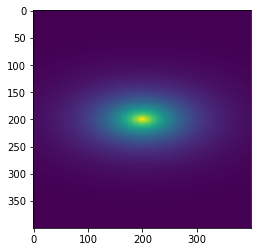

In [19]:
N = 200
[x, y] = np.meshgrid(np.arange(-N, +N, 1), np.arange(-N, +N, 1))

im_data = model(x,y)

plt.imshow(im_data)

# Check Normalization

Check to see if normalization is the same as sum under r_eff * 20

In [7]:
model.normalization

59742.19997239601

In [8]:
N = model.r_eff * 20
x, y = np.meshgrid(np.arange(-N, +N, 1), np.arange(-N, +N, 1))

im_data = model(x,y)

im_data.sum(), model.normalization, im_data.sum() - model.normalization, im_data.sum()/model.normalization

(59742.51059019933, 59742.19997239601, 0.31061780331947375, 1.0000051993030632)

# Check npix

In [9]:
N = int(model.r_eff * 3)
x, y = np.meshgrid(np.arange(-N, +N, 1), np.arange(-N, +N, 1))

im_data = model(x,y)
im_data.shape

(600, 600)

In [10]:
del_x = 156
noise_level = im_data[N][N+del_x]
N + del_x, noise_level

(456, 0.39067693473421755)

In [11]:
argmin = abs(im_data[N, N:] - noise_level).argmin()
argmin

156

Now make a function for the model

In [13]:
del_x = 156

noise_level = im_data[N][N+del_x]
total_flux = model.normalization
max_npix=N

x = np.arange(0, max_npix, 1)

values = total_flux*(model.model_1d(x)/model.normalization)

if noise_level > values[0]:
    raise Exception("Noise too large, max noise = {}".format(values[0]))

if noise_level < values[-1]:
    raise Exception("Noise too small, min noise = {}".format(values[-1]))

argmin = abs(values - noise_level).argmin()

int(x[argmin]) 

156

Test the function

In [15]:
del_x = 156

total_flux = 145646404889 # Some random number
noise_level = total_flux * (im_data[N][N+del_x]/model.normalization)

model.compute_npix(noise_level, total_flux, max_pix=N)

156

# Oversampled

In [33]:
N = int(model.r_eff * 3)
x, y = np.meshgrid(np.arange(-N, +N, 1), np.arange(-N, +N, 1))

im_data = model(x,y)
im_data.shape

(600, 600)

In [55]:
del_x = 156

oversample = 5

total_flux = 145646404889 # Some random number

noise_level = 4762185.778510361 # in the actual image 
noise_level /= oversample # Downsample value

model.compute_npix(noise_level, total_flux, max_pix=N) // oversample

31

# Test rebin

In [5]:
def rebin(a, *args):
    """
    rebin ndarray data into a smaller ndarray of the same rank whose dimensions
    are factors of the original dimensions. eg. An array with 6 columns and 4 rows
    can be reduced to have 6,3,2 or 1 columns and 4,2 or 1 rows.
    example usages:
    >>> a=rand(6,4); b=rebin(a,3,2)
    >>> a=rand(6); b=rebin(a,2)
    """
    shape = a.shape
    lenShape = len(shape)
    factor = (np.asarray(shape) / np.asarray(args)).astype('int64')
    #   print(np.asarray(shape).dtype,np.asarray(args).dtype,factor.dtype)
    evList = ['a.reshape('] + \
             ['args[%d],factor[%d],' % (i, i) for i in range(lenShape)] + \
             [')'] + ['.sum(%d)' % (i + 1) for i in range(lenShape)] \
        #             + ['/factor[%d]'%i for i in range(lenShape)]
    #   print(''.join(evList))
    return eval(''.join(evList))

In [12]:
a=np.random.rand(6,4)
for i in range(len(a)):
    a[i] = 1#np.arange(len(a[0]))#+(i*len(a[0]))
a, a.shape

(array([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]), (6, 4))

In [13]:
b = rebin(a,3,2)

In [14]:
b

array([[4., 4.],
       [4., 4.],
       [4., 4.]])